In [9]:
import os
import cv2
import scipy
import pydicom

import numpy as np
import pandas as pd
import SimpleITK as sitk
import matplotlib.pyplot as plt

from tqdm import tqdm

# conda install -c simpleitk simpleitk
# conda install -c conda-forge pydicom

In [2]:
def load_input(file_path, is_dicom=True):
    if is_dicom:
        try:
            header = pydicom.dcmread(file_path, force=True)
            img = header.pixel_array
            img = np.array(img)
            if len(img.shape) >= 3:
                img = img[:, :, 0]
            if header.PhotometricInterpretation.lower().strip() == "monochrome1":
                img = np.max(img) - img
        except:
            try:
                header = sitk.ReadImage(file_path)
                img = sitk.GetArrayFromImage(header).astype("float32")
                img = np.squeeze(img)
                if len(img.shape) >= 3:
                    img = img[:, :, 0]

                if header.GetMetaData("0028|0004").lower().strip() == "monochrome1":
                    img = np.max(img) - img
            except:
                message = "invalid DICOM file"
                return message
    else:
        img = cv2.imread(file_path, -1)
        img = np.array(img)
        if len(img.shape) >= 3:
            img = img[:, :, 0]
    img = img.astype('float32')
    
    if img.min() < 0:
        img -= np.min(img)
    
    return img


def windowing(img, eps, training=False):
    img = img.copy()
    center = np.mean(img)
    if training:
        width_param = 3.5 + random.random()
    else:
        width_param = 4.
    width = np.std(img) * width_param
    low = center - width / 2
    high = center + width / 2
    
    img[img < low] = low
    img[img > high] = high
    
    return img

In [10]:
# kaggle competitions download -c vinbigdata-chest-xray-abnormalities-detection

DATA_DIR = '/data/younjoon/VinDRCXR/'
csv_path = DATA_DIR + 'train.csv'
df = pd.read_csv(csv_path)
df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN


In [5]:
disease_names = [
    '00AorticEnlargement',
    '01Atelectasis',
    '02Calcification',
    '03Cardiomegaly',
    '04Consolidation',
    '05ILD',
    '06Infiltration',
    '07LungOpacity',
    '08Nodule/Mass',
    '09Other',
    '10PleuralEffusion', 
    '11PleuralThickening', 
    '12Pneumothorax', 
    '13PulmonaryFibrosis', 
    '14Normal' 
]

tot_num = len(df['image_id'].unique())
print('Total number of images: ', tot_num)

names = []
counts = []

for i, disease_name in enumerate(disease_names):
    disease_name = disease_names[i][2:]
    disease_id = int(disease_names[i][:2])
    disease_num = len(df[df['class_id'] == disease_id]['image_id'].unique())

    names.append(disease_name)
    counts.append(disease_num)

    print(f'{disease_id:02d} {disease_name:20s} {disease_num:5d}')

Total number of images:  15000
00 AorticEnlargement     3067
01 Atelectasis            186
02 Calcification          452
03 Cardiomegaly          2300
04 Consolidation          353
05 ILD                    386
06 Infiltration           613
07 LungOpacity           1322
08 Nodule/Mass            826
09 Other                 1134
10 PleuralEffusion       1032
11 PleuralThickening     1981
12 Pneumothorax            96
13 PulmonaryFibrosis     1617
14 Normal               10606


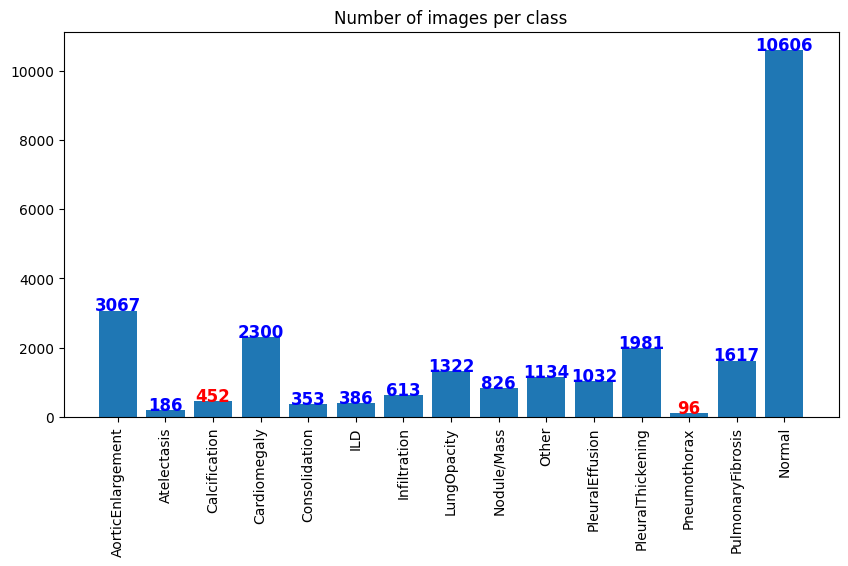

In [11]:
# Plot the histogram of the number of images per class
plt.figure(figsize=(10, 5))

# Plot text on each bar
for i, v in enumerate(counts):
    if i == 12 or i == 2:
        color = 'red'
    else:
        color = 'blue'
    plt.text(i, v + 0.1, str(v), color=color, fontweight='bold', fontsize=12, horizontalalignment='center')

plt.title('Number of images per class')
plt.bar(names, counts)
plt.xticks(rotation=90)
plt.show()


(3159, 2954) 0.0 4095.0
(3159, 2954) 740.47534 4095.0


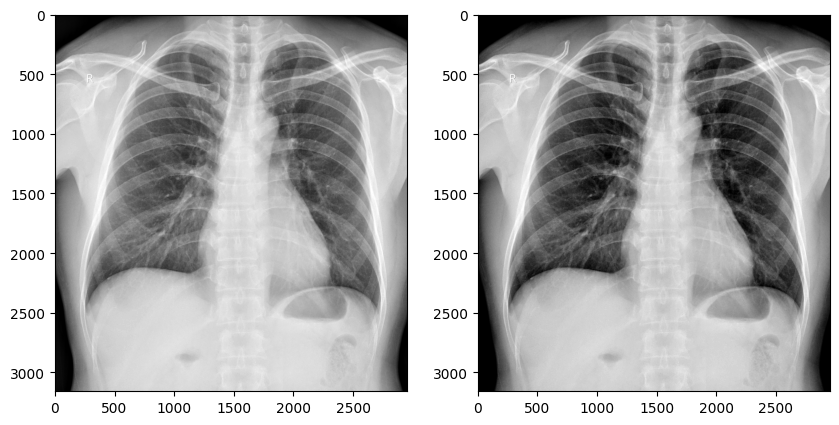

In [71]:
# Example visualization

img_id = df['image_id'].unique()[1]
img_path = DATA_DIR + 'train/' + img_id + '.dicom'
img  = load_input(img_path)
img_ = windowing(img, 1e-6)

print(img.shape, np.min(img), np.max(img))
print(img_.shape, np.min(img_), np.max(img_))

# Plot side by side
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1); plt.imshow(img, cmap='gray')
plt.subplot(1, 2, 2); plt.imshow(img_, cmap='gray')

In [13]:
# Convert selected DICOM files to npy
# Saving normal images (Randomly selected 300 images)
normal_img_ids = df[df['class_id'] == 14]['image_id'].unique()
normal_img_ids = np.random.choice(normal_img_ids, 152, replace=False)
for img_id in tqdm(normal_img_ids):
    img_path = DATA_DIR + 'train/' + img_id + '.dicom'
    img  = load_input(img_path)
    
    # save img as a npy file
    np.save(DATA_DIR + 'npy/Normal/' + img_id + '.npy', img)

# Saving abnormal images (Pneumothorax)
# ptx_img_ids = df[df['class_id'] == 2]['image_id'].unique()
# for img_id in tqdm(ptx_img_ids):
#     img_path = DATA_DIR + 'train/' + img_id + '.dicom'
#     img  = load_input(img_path)
    
#     # save img as a npy file
#     np.save(DATA_DIR + 'npy/Calcification/' + img_id + '.npy', img)

  4%|▍         | 6/152 [00:00<00:10, 13.49it/s]/home/younjoon/.conda/envs/ldm/lib/python3.8/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
  9%|▊         | 13/152 [00:08<01:51,  1.25it/s]/home/younjoon/.conda/envs/ldm/lib/python3.8/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (14-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
100%|██████████| 152/152 [01:35<00:00,  1.59it/s]


In [11]:
# Convert all DICOM files to npy
for img_id in tqdm(df['image_id'].unique()):
    img_path = DATA_DIR + 'train/' + img_id + '.dicom'
    img  = load_input(img_path)
    
    # save img as a npy file
    save_path = DATA_DIR + 'npy/' + img_id + '.npy'
    if os.path.exists(save_path):
        continue
    np.save(DATA_DIR + 'npy/' + img_id + '.npy', img)

  0%|          | 0/15000 [00:00<?, ?it/s]/home/younjoon/.conda/envs/ldm/lib/python3.8/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (14-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
  0%|          | 1/15000 [00:01<6:51:13,  1.65s/it]/home/younjoon/.conda/envs/ldm/lib/python3.8/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
  6%|▌         | 833/15000 [08:33<1:58:24,  1.99it/s]